## Trimming

In [9]:
# trim_memory_chat.py

import os
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.checkpoint.memory import InMemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.messages.utils import trim_messages, count_tokens_approximately

load_dotenv()

def get_groq_llm():
    return ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7, max_tokens=2000
    )

model = get_groq_llm()

MAX_TOKENS = 120

def chat(state: MessagesState):
    trimmed_messages = trim_messages(
        state["messages"],
        strategy="last",
        token_counter=count_tokens_approximately,
        max_tokens=MAX_TOKENS,
    )

    response = model.invoke(trimmed_messages)
    return {"messages": [response]}



In [10]:
builder = StateGraph(MessagesState)
builder.add_node("chat", chat)
builder.add_edge(START, "chat")

graph = builder.compile(checkpointer=InMemorySaver())

config = {"configurable": {"thread_id": "trim-demo"}}



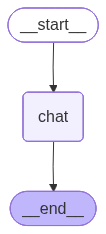

In [11]:
graph

In [12]:
while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        break
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config)
    print("Bot:", result["messages"][-1].content)

Bot: Hello Sachin! 👋 How can I help you today?
Bot: That’s awesome! Quantum physics can feel a bit mystical at first, but it’s also incredibly logical once you get into the math and concepts.  
Here are a few ways I can help you get started (or deepen your knowledge):

| Topic | What it’s about | Quick takeaway | Suggested next step |
|-------|-----------------|----------------|---------------------|
| **Wave–particle duality** | Light and matter act like both waves and particles. | Interference patterns (double‑slit) show wave behavior; photoelectric effect shows particle behavior. | Watch a short animation (e.g., “Quantum Mechanics for Dummies” on YouTube). |
| **Uncertainty principle** | You can’t know a particle’s position *and* momentum precisely at the same time. | \(\Delta x \, \Delta p \ge \hbar/2\). | Try a simple simulation (PhET’s “Uncertainty Principle” interactive). |
| **Quantum superposition** | A system can be in multiple states simultaneously. | Schrödinger’s cat is a 

## Deletion

In [13]:
# delete_memory_chat.py

import os
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.checkpoint.memory import InMemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.messages import RemoveMessage

load_dotenv(override=True)

def get_groq_llm():
    return ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7, max_tokens=2000
    )

model = get_groq_llm()

def chat(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": [response]}

def cleanup(state: MessagesState):
    messages = state["messages"]

    if len(messages) > 6:
        to_remove = messages[:4]  # delete oldest messages
        return {"messages": [RemoveMessage(id=m.id) for m in to_remove]}

    return {}



In [14]:
builder = StateGraph(MessagesState)
builder.add_node("chat", chat)
builder.add_node("cleanup", cleanup)

builder.add_edge(START, "chat")
builder.add_edge("chat", "cleanup")
builder.add_edge("cleanup", "__end__")

graph = builder.compile(checkpointer=InMemorySaver())

config = {"configurable": {"thread_id": "delete-demo"}}



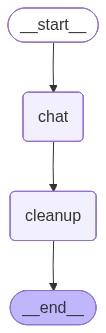

In [15]:
graph

In [16]:
while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        break
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config)
    print("Bot:", result["messages"][-1].content)

Bot: Hello Sachin! 👋 How can I assist you today?
Bot: That’s awesome, Sachin! 🚀 Data science is a huge field, but a few focused steps can make it a lot more manageable. Let’s start by figuring out where you’re at and what you’d like to focus on next.  

---

## Quick Self‑Check

| Topic | What you might already know | What you might still need |
|-------|----------------------------|---------------------------|
| **Programming** | Python (or R) basics | Advanced libraries (pandas, NumPy, scikit‑learn, etc.) |
| **Math & Stats** | Descriptive stats | Probability theory, hypothesis testing, linear regression, etc. |
| **Machine Learning** | Maybe a few algorithms | Model evaluation, hyper‑parameter tuning, pipelines |
| **Data Wrangling** | Loading CSVs | Cleaning, merging, dealing with missing data |
| **Visualization** | Basic plots | Interactive dashboards (Plotly, Bokeh), storytelling |
| **Domain Knowledge** | None | Pick a niche (health, finance, marketing, etc.) |
| **Tools** | Gi

In [ ]:
# ---- Run ----
graph.invoke({"messages": [{"role": "user", "content": "Hi, I'm Sachin"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "I am learning LangGraph"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "Explain short term memory"}]}, config)
result = graph.invoke({"messages": [{"role": "user", "content": "What is my name?"}]}, config)

print(result["messages"][-1].content)


## Summarization

In [26]:
# summary_memory_chat.py

import os
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.checkpoint.memory import InMemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, RemoveMessage

load_dotenv(override=True)

def get_groq_llm():
    return ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7, max_tokens=2000
    )

model = get_groq_llm()

class ChatState(MessagesState):
    summary: str

def chat(state: ChatState):
    messages = []

    if state["summary"]:
        messages.append({
            "role": "system",
            "content": f"Conversation summary:\n{state['summary']}"
        })

    messages.extend(state["messages"])
    response = model.invoke(messages)
    return {"messages": [response]}

def summarize(state: ChatState):
    prompt = "Summarize the conversation so far. in a way that you can include important details in future interactions. like name of the person you  are talking & other deatils."

    summary_input = state["messages"] + [HumanMessage(content=prompt)]
    response = model.invoke(summary_input)

    to_delete = state["messages"][:-2]

    return {
        "summary": response.content,
        "messages": [RemoveMessage(id=m.id) for m in to_delete],
    }

def should_summarize(state: ChatState):
    return len(state["messages"]) > 6



In [27]:
builder = StateGraph(ChatState)
builder.add_node("chat", chat)
builder.add_node("summarize", summarize)

builder.add_edge(START, "chat")
builder.add_conditional_edges(
    "chat",
    should_summarize,
    {True: "summarize", False: "__end__"}
)
builder.add_edge("summarize", "__end__")

graph = builder.compile(checkpointer=InMemorySaver())

config = {"configurable": {"thread_id": "summary-demo"}}


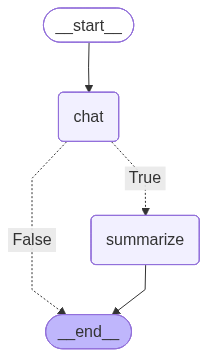

In [28]:
graph


In [20]:
while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        break
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}],"summary":""}, config)
    print("Bot:", result["messages"][-1].content)

Bot: Hello Sachin! 👋 How can I help you today?
Bot: ## 🚀 AI Learning Road‑Map (From Zero to “I Can Build an AI Model”)

> **TL;DR**  
> 1️⃣ Foundations (3–4 mo) – math + programming  
> 2️⃣ Core AI/ML (4–6 mo) – supervised, unsupervised, evaluation  
> 3️⃣ Deep Learning & frameworks (3–4 mo) – neural nets, PyTorch/TensorFlow  
> 4️⃣ Projects & portfolio (ongoing) – Kaggle, open‑source, capstone  
> 5️⃣ Specialization & career (12 mo+) – choose a niche, get certified, network

> **Total time to a solid “AI‑ready” skill set:** ~12–18 months (part‑time)  
> **If you’re full‑time or already have a data‑science background, you can cut it in half.**

---

## 1️⃣ Foundations – 3–4 Months

| Skill | Why it matters | Resources (free/cheap) | Suggested Time |
|-------|----------------|------------------------|----------------|
| **Python** | Industry‑standard language for AI | • *Automate the Boring Stuff* (free PDF) <br>• Codecademy “Learn Python 3” (free tier) <br>• LeetCode (Python track) | 1

In [29]:


# ---- Run ----
graph.invoke({"messages": [HumanMessage(content="Hi, I'm Sachin")], "summary": ""}, config)
graph.invoke({"messages": [HumanMessage(content="I am learning LangGraph")], "summary": ""}, config)
graph.invoke({"messages": [HumanMessage(content="Explain short term memory")], "summary": ""}, config)
result = graph.invoke({"messages": [HumanMessage(content="What is my name?")], "summary": ""}, config)

print(result["messages"][-1].content)

Your name is Sachin.
